<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/learning_tf_simple_cnn_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [ ]:
import os, sys, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix

from keras.callbacks import EarlyStopping
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


#TPU detection

In [ ]:
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


#Configuration

In [ ]:
PATH_PATTERN = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/root_dataset/tfrec_image_data/tfrecords-jpeg-180x180-nnn/*.tfrec'
IMAGE_SIZE = [180, 180]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.3

CLASSES = ['nonclickbaits', 'clickbaits'] # do not change, maps to the labels in the data (folder names)


# splitting data files between training and validation
filenames = tf.io.gfile.glob(PATH_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(15335 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(15335 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 12 training files and 4 validation files
With a batch size of 32, there will be 359 batches per training epoch and 119 batch(es) per validation run.


In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

#Read images and labels from TFRecords

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [2])
    class_label = example['class']
    # we had saved data as 0 for clickbaits and 1 for non-clickbaits, reversing that mistake here
    if class_label == 0:
      class_label = 1
    else:
      class_label = 0
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO) 
  return dataset

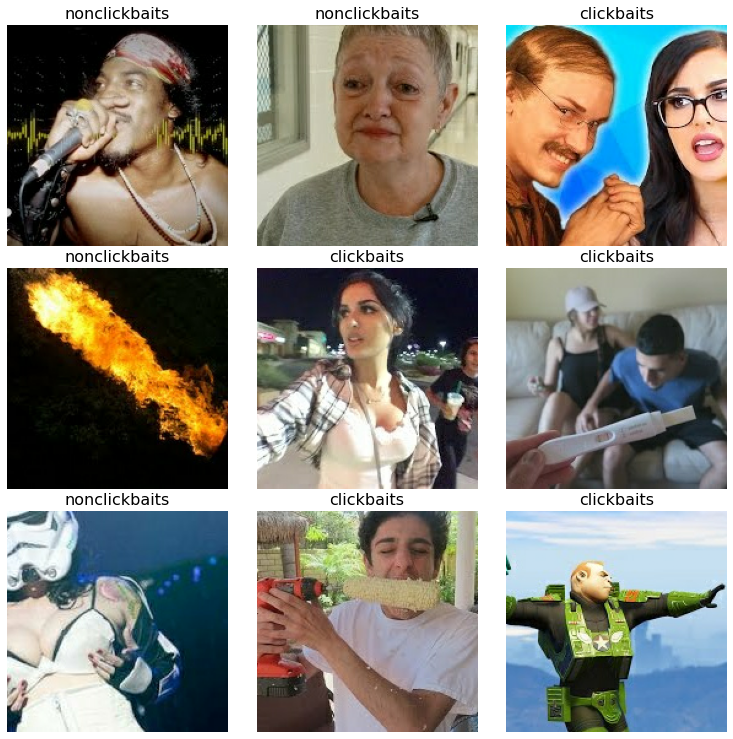

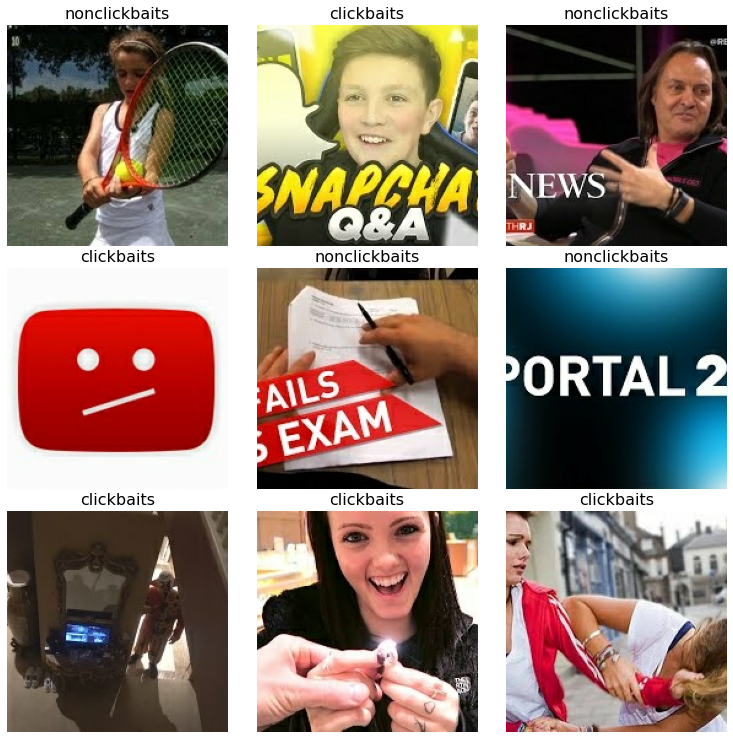

In [ ]:
#@title Train & Validation data visualization 
display_9_images_from_dataset(load_dataset(training_filenames))
display_9_images_from_dataset(load_dataset(validation_filenames))

#training and validation datasets

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)


In [ ]:
some_thumbnails, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

#Model 

In [ ]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  es = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
 ]

  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=METRICS)

  model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 30)      4350      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 30)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 60)        16260     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 90)        48690     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 90)       

#Training

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/clickbait_detection/model_path'
model_path = os.path.join(save_path,'simple_cnn_tfrec.tf')

In [ ]:
if os.path.exists(model_path):
 model = tf.keras.models.load_model(model_path)

In [ ]:
EPOCHS = 10

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset,  callbacks=[es])

Epoch 1/10
359/359 [==============================] - 25s 63ms/step - loss: 0.4671 - tp: 3784.0000 - fp: 1348.0000 - tn: 4939.0000 - fn: 1417.0000 - accuracy: 0.7593 - precision: 0.7373 - recall: 0.7276 - auc: 0.8513 - prc: 0.8284 - val_loss: 0.5707 - val_tp: 929.0000 - val_fp: 377.0000 - val_tn: 1729.0000 - val_fn: 801.0000 - val_accuracy: 0.6929 - val_precision: 0.7113 - val_recall: 0.5370 - val_auc: 0.7741 - val_prc: 0.7387
Epoch 2/10
359/359 [==============================] - 22s 61ms/step - loss: 0.4429 - tp: 3877.0000 - fp: 1236.0000 - tn: 5050.0000 - fn: 1325.0000 - accuracy: 0.7771 - precision: 0.7583 - recall: 0.7453 - auc: 0.8673 - prc: 0.8464 - val_loss: 0.5721 - val_tp: 993.0000 - val_fp: 419.0000 - val_tn: 1687.0000 - val_fn: 737.0000 - val_accuracy: 0.6986 - val_precision: 0.7033 - val_recall: 0.5740 - val_auc: 0.7736 - val_prc: 0.7377
Epoch 3/10
359/359 [==============================] - 22s 60ms/step - loss: 0.4214 - tp: 3904.0000 - fp: 1174.0000 - tn: 5115.0000 - fn: 1

In [ ]:
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/clickbait_detection/model_path/simple_cnn_tfrec.tf/assets


#Plot training history

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

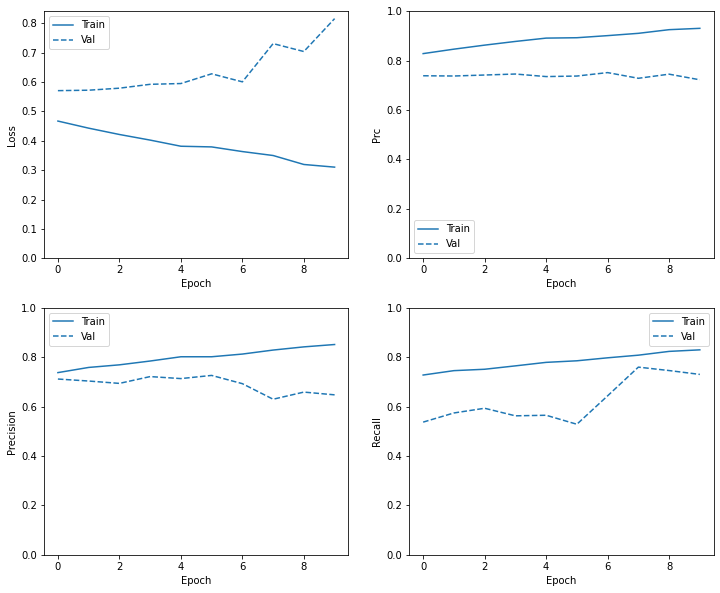

In [ ]:
plot_metrics(history)

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_prc'])


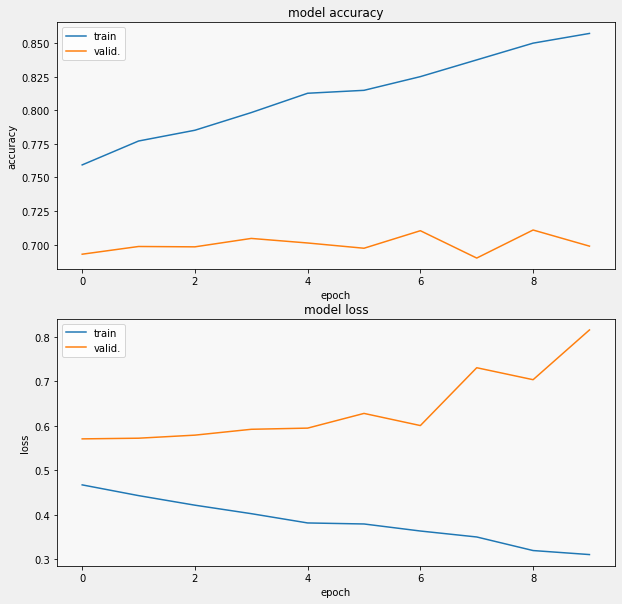

In [ ]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

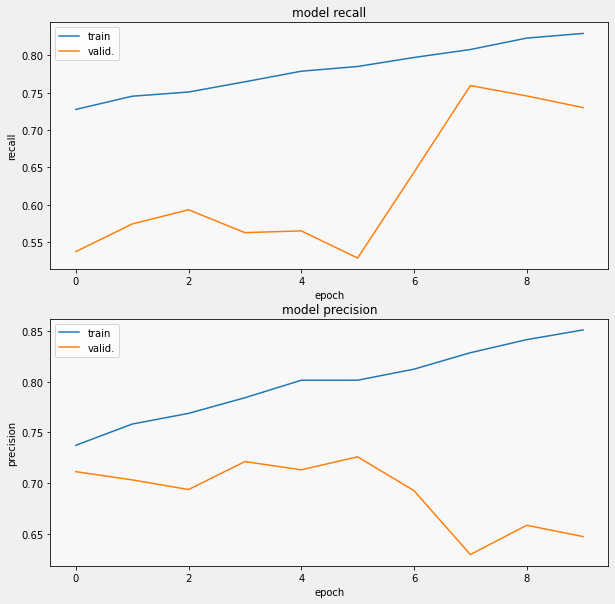

In [ ]:
display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Predictions

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non clickbaits Detected (True Negatives): ', cm[0][0])
  print('Non-Clickbaits Detected as Clickbaits (False Positives): ', cm[0][1])
  print('Clickbaits Detected as Non-clickbaits (False Negatives): ', cm[1][0])
  print('Clickbaits Detected (True Positives): ', cm[1][1])
  print('Total Non-clickbaits: ', np.sum(cm[0]))
  print('Total Clickbaits: ', np.sum(cm[1]))

In [ ]:
def display_9_images_with_predictions_1(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [ ]:
model = tf.keras.models.load_model(model_path)

In [ ]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_thumbnails, some_labels = (some_thumbnails[permutation], some_labels[permutation])

predictions = model.predict(some_thumbnails, batch_size=16)
results = model.evaluate(some_thumbnails, some_labels, batch_size=16)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()
  
#print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
#print(f'[val_accuracy : {evaluations[-5]}, val_precision : {evaluations[-4]}, val_recall : {evaluations[-3]}, val_auc : {evaluations[-2]}, val_prc : {evaluations[-1]}]')

10/10 [==============================] - 1s 17ms/step - loss: 0.9847 - tp: 38.0000 - fp: 36.0000 - tn: 59.0000 - fn: 27.0000 - accuracy: 0.6062 - precision: 0.5135 - recall: 0.5846 - auc: 0.6983 - prc: 0.5865
loss :  0.9847376942634583
tp :  38.0
fp :  36.0
tn :  59.0
fn :  27.0
accuracy :  0.606249988079071
precision :  0.5135135054588318
recall :  0.5846154093742371
auc :  0.6982995867729187
prc :  0.5864701271057129



Non clickbaits Detected (True Negatives):  59
Non-Clickbaits Detected as Clickbaits (False Positives):  36
Clickbaits Detected as Non-clickbaits (False Negatives):  27
Clickbaits Detected (True Positives):  38
Total Non-clickbaits:  95
Total Clickbaits:  65


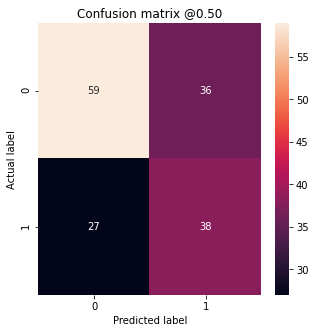

In [ ]:
plot_cm(some_labels, predictions)

In [ ]:
predictions = np.array(list(map( lambda x: 1 if x > 0.5 else 0 , predictions )))

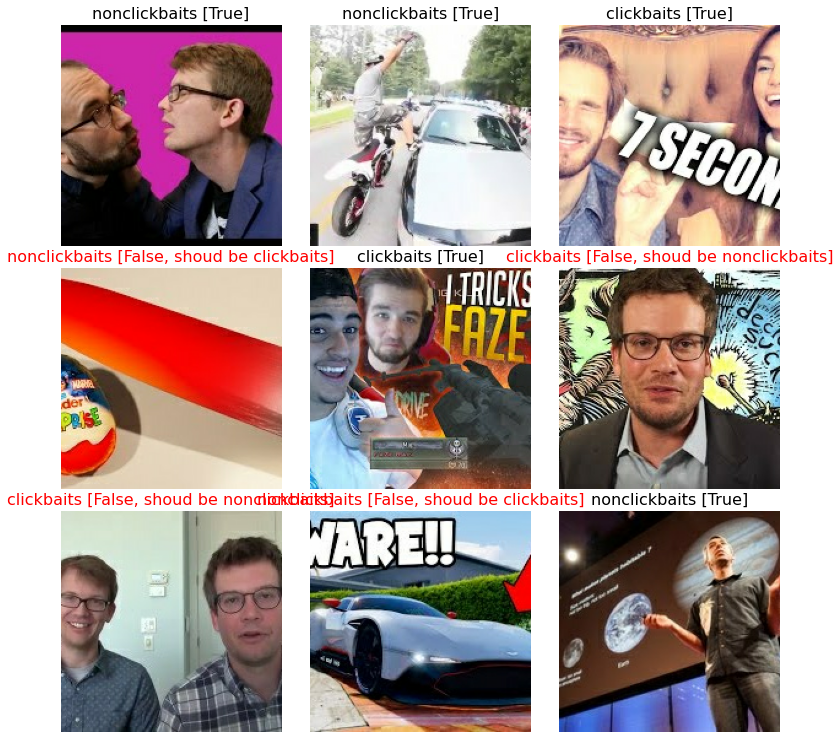

In [ ]:
display_9_images_with_predictions_1(some_thumbnails, predictions, some_labels)